In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Proposal 

    I will be analyzing data provided by Vice News about Police Involved shootings across the U.S. The source of the data and raw data can be accessed at this site: https://news.vice.com/en_us/article/a3jjpa/nonfatal-police-shootings-data. Vice collected the data, which is information about shootings involving police, both fatal and non-fatal, from the 50 largest Police Precincts in the U.S. I will attempt to build a model(s) that accurately categorize whether a shooting is fatal or non. Of the most interest to me is the contributing factors, because I am confident that by looking at the coefficients I can get an accurate picture of how the situations differ between Fatal and Non-Fatal instances of police discharging their weapons. With this information, I hope to be able to make recommendations to police departments about actions they can take to minimize the chances of killing their suspects. 
    
    I understand that the Police do their best to protect people, and themselves, from dangerous criminals and that they deal with dangerous situations on a daily basis and are constantly trying to balance apprehending a criminal and making sure that they don't get hurt themselves in the process. With this data I hope to be able to provide valuable information about how Police officers can approach these situations to minimize the chances of anyone dying. 
    
If we can predict why fatalities happen, maybe we can help reduce the likelihood of them occurring. 

# Imports

In [2]:
import pandas as pd
import seaborn as sns
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.compose import ColumnTransformer
from category_encoders import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.calibration import calibration_curve

from sklearn.feature_selection import SelectKBest, f_classif

from functions_pkg import print_vif, predictions_df

from xgboost import XGBClassifier

from mlxtend.plotting import plot_decision_regions


%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# function used for finding the VIF, provided by Adam

def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
# Load in Data
path = "https://raw.githubusercontent.com/WoodyBurns44/thinkful/main/ViceNews_FullOISData%20-%20Sheet1.csv"

df = pd.read_csv(path)

<IPython.core.display.Javascript object>

In [5]:
df.head(2)

,Date,NumberOfSubjects,Fatal,SubjectArmed,SubjectRace,SubjectGender,SubjectAge,NatureOfStop,NumberOfShots,NumberOfOfficers,OfficerRace,OfficerGender,Department,FullNarrative,City,Notes
0,3/4/2010,1,N,N,L,U,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,motorized vehicle; no hits
1,1/9/2010,1,F,Y,W,M,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,NaN
2,6/10/2010,1,F,Y,W,M,U,NaN,NaN,2,W;W,M;M,Albuquerque Police Department,NaN,Albuquerque,NaN
3,11/10/2010,1,N,Y,U,M,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,NaN
4,11/11/2010,1,N,Y,L,M,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,NaN


<IPython.core.display.Javascript object>

In [6]:
# Seperate descriptive columns for language analysis
language_df = df[["Fatal", "NatureOfStop", "FullNarrative", "Notes"]]

<IPython.core.display.Javascript object>

In [7]:
# Drop language categories
# Drop Number of Subjects, redundant because all values are 1.
df = df.drop(columns=["NatureOfStop", "FullNarrative", "Notes", "NumberOfSubjects"])

<IPython.core.display.Javascript object>

## Data Cleaning, exploration, and feature engineering

In [8]:
# TODO: Cleaning and preperation
# - 'Date' - extract year, month, maybe drop - *
# - 'NumberOfSubjects' is redundant, all values are 1 - *
# - 'Fatal' - Standardize Values - *
# - 'SubjectArmed' - Standardize Values - *
# - 'SubjectRace' - Deal with na's - *
# - 'SubjectGender' - deal with 2 na's - *
# - 'SubjectAge' - deal with 3 na's, group by 10 years - *
# - 'NatureOfStop' - Create "Other" value, deal with high # of NA's
# - 'NumberOfShots' - combine when multiple officers are involved - *
# - 'NumberOfOfficers' - standardize values and group - *
# - 'OfficerRace' - Create "multiple Officer value", create 'minority officer involved' variable
# - 'OfficerGender' - Standadize and create 'multiple_officer' and 'female present' cats
# - 'Department' - Redundant, since city is listed
# - 'FullNarrative' - NLP? Has FN? SKLEARN.feature_extraction.text TFIDF vectorizer
# - 'City' - Might be redundant, Check out in EDA, drop for model
# - 'Notes' - What to do with them, maybe do some NLP

# Wordclouds - Fatal and Not Fatal

<IPython.core.display.Javascript object>

### Target Variable - Fatal

In [9]:
# Cleaning N and F with spaces
df["Fatal"].replace({" N": "N", " F": "F"}, inplace=True)
# Since Fatality is target, Dropping Rows where Fatality is unknown
unknown_fatals = df[df["Fatal"] == "U"].index
df = df.drop(unknown_fatals, axis=0)

<IPython.core.display.Javascript object>

### Date

In [10]:
# Convert to datetime format
df["Date"] = pd.to_datetime(df["Date"])
# Extract Year and Month
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
# Drop original Date column
df = df.drop(columns="Date")

<IPython.core.display.Javascript object>

### Subject Armed

In [11]:
df["SubjectArmed"].value_counts()
# Fix syntatical issues
df["SubjectArmed"].replace("Y ", "Y", inplace=True)
# Filling Nan values with U for Unknown
df["SubjectArmed"] = df["SubjectArmed"].fillna("U")

<IPython.core.display.Javascript object>

### Subject Race

In [12]:
df["SubjectRace"].isna().sum()
df["SubjectRace"] = df["SubjectRace"].fillna("U")
df["SubjectRace"].value_counts()

B    1604
U    1152
L     667
W     637
A      38
O      14
Name: SubjectRace, dtype: int64

<IPython.core.display.Javascript object>

### Subject Gender


In [13]:
# df[df['SubjectGender'] == 'M;U']
df["SubjectGender"].replace("M;U", "M", inplace=True)

<IPython.core.display.Javascript object>

### Subject Age

In [14]:
# df["SubjectAge"].unique()
# df[df['SubjectAge'] == '20-29']
# df[df['SubjectAge'] == '0-19']
# df[df['SubjectAge'] == '30-39']
# df[df['SubjectAge'] == 'Juvenile']

# When age ranges are given, replace with average of range.
# Except for 0-19, which I am treating as 17 year olds because
# after doing some research, that seems like the average age of
# young people involved in incidents. In the case of "Juvenile",
# I set that to 17 as well for the same reason.
df["SubjectAge"].replace(
    {
        "UNKNOWN": "U",
        "0-19": "17",
        "20-29": "25",
        "30-39": "35",
        "40-49": "45",
        "50-59": "55",
        "NaN": "U",
        "Juvenile": "17",
        "21-23": "22",
    },
    inplace=True,
)

df["SubjectAge"].fillna("U", inplace=True)

# df["SubjectAge"].isna().sum()

<IPython.core.display.Javascript object>

### Number of Officers

In [15]:
# When Number of Officers is represented with a '>', I rounded up
# to the nearest number divisible by 2, since officers usually have
# a partner.
# Replaced any instance of zero officers with 1, since there must have been
# at least one officer there.
df["NumberOfOfficers"].replace(
    {
        ">1": 2,
        "2 or multiple_officer": 2,
        ">2": 4,
        ">5": 6,
        ">3": 4,
        ">6": 8,
        ">7": 8,
        "2 or More": 2,
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

### Officer Race

In [16]:
# Transform Officer race variables into binary features
# Indicating which races of officers were involved in the occurance


df.OfficerRace.fillna("U", inplace=True)
races = df.OfficerRace.copy()
races_split = races.str.split(";")
unique_races = []
for race in races_split:
    for val in race:
        if val == "WHITE":
            val = "W"
        blk = ["BLACK", "Other:B", "W:B"]
        if val in blk:
            val = "B"
        api = ["A/PI", "AI/AN", "A/PI Unknown"]
        if val in api:
            val = "A"
        hisp = ["H", "W/H", "W/ H", "H: H", "H/L"]
        if val in hisp:
            val = "L"
        asian = [
            "ASIAN",
            "A/W",
            "W/A",
        ]
        if val in asian:
            val = "A"
        uk = ["Unknown", "Unknown ", "NA", "U "]
        if val in uk:
            val = "U"
        wt = ["W:W", "NA/W"]
        if val in wt:
            val = "W"
        oth = ["I", "m/m", "M", "Multi-Racial"]
        if val in oth:
            val = "O"
        if val in unique_races:
            continue
        else:
            unique_races.append(val)


df["races_split"] = races_split
races_split = df.races_split.to_list()
unique_races[1] = "H"
cats = [
    "White Officer Involved",
    "Latino Officer Involved",
    "officer_U",
    "Black Officer Involved",
    "Asian Officer Involve",
    "Other Race Officer Involved",
]

officers = []
for j in range(len(races_split)):
    off = []
    for race in unique_races:
        if race in races_split[j]:
            off.append(1)
        else:
            off.append(0)
    officers.append(off)


off_df = pd.DataFrame(officers, columns=cats)
# off_df

df.reset_index(inplace=True)

df.drop(columns=["index"], inplace=True)
# df

df = df.join(off_df)
df.drop(columns=["OfficerRace"], inplace=True)
df.head(2)

,Fatal,SubjectArmed,SubjectRace,SubjectGender,SubjectAge,NumberOfShots,NumberOfOfficers,OfficerGender,Department,City,Year,Month,races_split,White Officer Involved,Latino Officer Involved,officer_U,Black Officer Involved,Asian Officer Involve,Other Race Officer Involved
0,N,N,L,U,U,NaN,1,M,Albuquerque Police Department,Albuquerque,2010,3,[W],1,0,0,0,0,0
1,F,Y,W,M,U,NaN,1,M,Albuquerque Police Department,Albuquerque,2010,1,[W],1,0,0,0,0,0


<IPython.core.display.Javascript object>

### Officer Gender

In [17]:
# Fill null Officer gender values with U
df.OfficerGender.fillna("U", inplace=True)
genders = df.OfficerGender.copy()
# Since genders are values sperated by ';', have to split 
gender_split = genders.str.split(";")
# Get unique genders and transforms variations of records 
# of the same genders
unique_genders = []
for gender in gender_split:
    for val in gender:
        male = ["M", "M ", "M:M", "/M", "Male", "M: M", "MALE", " /M"]
        if val in male:
            val = "M"
        unknwn = ["Unknown", "N", "U", ""]
        if val in unknwn:
            val = "U"
        female = ["F", "W", "FEMALE"]
        if val in female:
            val = "F"
        if val in unique_genders:
            continue
        else:
            unique_genders.append(val)

unique_genders

['M', 'F', 'U']

<IPython.core.display.Javascript object>

In [18]:
# Create list of Officer Genders to work on
df["Officer Genders"] = gender_split
gender_split = df["Officer Genders"].to_list()
cats = ["Male Officer Present", "Female Officer Present", "Unknown Officer Present"]

# Create binary gender variable
officer_g = []
for j in range(len(gender_split)):
    off_g = []
    for gender in unique_genders:
        if gender in gender_split[j]:
            off_g.append(1)
        else:
            off_g.append(0)
    officer_g.append(off_g)


off_g_df = pd.DataFrame(officer_g, columns=cats)
df = df.join(off_g_df)
df = df.drop(columns="Unknown Officer Present")

<IPython.core.display.Javascript object>

### Number of Shots Fired

In [20]:
# df["NumberOfShots"].unique()

# Replace string values with quanfitifiable information with integer values
df["NumberOfShots"].replace(
    {
        ">/=4": 4,
        ">/=8": 9,
        ">/=1": 1,
        ">/=2": 2,
        ">/=12": 12,
        ">/=3": 3,
        ">/=20": 20,
        ">/=5": 5,
        ">4": 5,
        ">2": 3,
        "1*": 1,
        ">3": 4,
        "3-5": 4,
        ">13": 14,
        "not clear": "U",
        "no information": "U",
        "Unknown": "U",
        "73 total": 73,
        "45 total ": 45,
        "4-5": 5,
        "Multiple": 4,
        ">1": 2,
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [21]:
# Fill Na's with "U"
df["NumberOfShots"].fillna("U")
# Create Total Shots Variable
df["Total_shots"] = pd.to_numeric(df["NumberOfShots"], errors="ignore")
df["Total_shots"].fillna("U", inplace=True)

# Seperate values with multiple officers involved that have ';' in description
mult_shots = df[df.Total_shots.str.contains(";") == True]

# Sum up all of the shots of eah officer
shots = []
for value in mult_shots["NumberOfShots"]:
    nums = value.split(";")
    nums = pd.to_numeric(nums)
    nums = nums.sum()
    shots.append(nums)


# replace multiple officer rows with summed values
df.loc[df.Total_shots.str.contains(";") == True, "Total_shots"] = shots

# Drop Number of Shots variable
df = df.drop(columns="NumberOfShots")

<IPython.core.display.Javascript object>

In [22]:
# Since there are so many Unknown values in shots fired,
# but I think there is value in that information, creating seperate
# Dataframe with that as the null subset and dropping from main DF
shots_df = df.copy()
no_shots_df = df.copy()

<IPython.core.display.Javascript object>

### Interesting Findings

In [27]:
subject_armed_df = df.copy()
unknown_unarmed = subject_armed_df[subject_armed_df["SubjectArmed"] == "U"].index
subject_armed_df = subject_armed_df.drop(unknown_unarmed, axis=0)

<IPython.core.display.Javascript object>

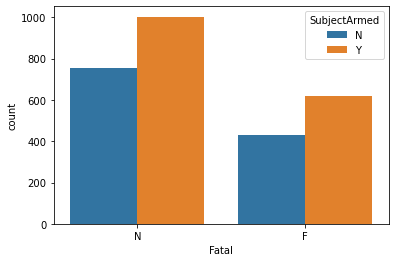

<IPython.core.display.Javascript object>

In [28]:
sns.countplot(x=subject_armed_df["Fatal"], hue=subject_armed_df["SubjectArmed"])
plt.show()

## Shots DF

In [ ]:
# Find and drop Unkown number of shots
unknown_shots = shots_df[shots_df["Total_shots"] == "U"].index
shots_df = shots_df.drop(unknown_shots)

In [ ]:
# Convert Subject age to numbers
shots_df["SubjectAge"] = pd.to_numeric(shots_df["SubjectAge"], errors="coerce")

# Fill Na's with mean age
mean_age = round(shots_df["SubjectAge"].mean(), 0)
shots_df["SubjectAge"].fillna(mean_age, inplace=True)

In [ ]:
# Convert Total Shots to numeric
shots_df["Total_shots"] = pd.to_numeric(shots_df["Total_shots"])

In [ ]:
# Convert Fatal column to numeric
shots_df["Fatal"] = shots_df["Fatal"].replace({"N": 0, "F": 1})

In [ ]:
# Change values to numeric, classifying 'U' the same as
# 'N' because if they dont know if the subject was armed
# Then for our purposes this is the same as the subject not
# being armed
shots_df["SubjectArmed"].replace({"N": 0, "Y": 1, "U": 0}, inplace=True)

In [ ]:
# Find the one missing value for Number of Officers
missing_officer_num = shots_df[shots_df["NumberOfOfficers"].isna()].index

In [ ]:
# Drop that value, since there is a lot of other missing info
# From that row
shots_df.drop(missing_officer_num, inplace=True)

In [ ]:
# shots_df[shots_df["NumberOfOfficers"] == "U"]
shots_df["NumberOfOfficers"].replace("U", 1, inplace=True)

In [ ]:
# Convert Number of Officers to numeric
shots_df["NumberOfOfficers"] = pd.to_numeric(shots_df["NumberOfOfficers"])

In [ ]:
# Convert age to log for normalization
shots_df["log_SubjectAge"] = np.log(shots_df["SubjectAge"])

In [ ]:
# Drop columns that are not of interest
shots_df = shots_df.drop(
    columns=[
        "Month",
        "officer_U",
        "Other Race Officer Involved",
        "Female Officer Present",
        "races_split",
        "Officer Genders",
        "Year",
        "Department",
        "SubjectAge",
        "City",
        "OfficerGender",
    ]
)

In [ ]:
# Creating Interaction variable for instances where there is a White Officer and Black Suspect

shots_df["W_officer_B_Subject"] = 0

shots_df.loc[
    (shots_df["White Officer Involved"] == 1) & (shots_df["SubjectRace"] == "B"),
    "W_officer_B_Subject",
] = 1

## No Shots DF

In [ ]:
# Drop Total Shots from this DataFrame
no_shots_df = no_shots_df.drop(columns="Total_shots")

In [ ]:
# Convert Target variable to binary numeric
no_shots_df["Fatal"].replace(
    {
        "N": 0,
        "F": 1,
    },
    inplace=True,
)

In [ ]:
# no_shots_df[no_shots_df["NumberOfOfficers"] == "U"]
no_shots_df["NumberOfOfficers"].replace({"U": 1}, inplace=True)

no_shots_df["NumberOfOfficers"] = pd.to_numeric(no_shots_df["NumberOfOfficers"])

In [ ]:
no_shots_df = no_shots_df.drop(columns="OfficerGender")

In [ ]:
no_shots_df["SubjectAge"] = pd.to_numeric(no_shots_df["SubjectAge"], errors="coerce")

# Fill Na's with mean subject age

mean_age = round(no_shots_df["SubjectAge"].mean(), 0)
no_shots_df["SubjectAge"].fillna(mean_age, inplace=True)

In [ ]:
# Drop remaining NA's
no_shots_df = no_shots_df.dropna()

In [ ]:
# Fatality Count Plot
sns.countplot(x=no_shots_df["Fatal"])
plt.show()

In [ ]:
# Fatality by Subject Age
sns.boxplot(x=no_shots_df["Fatal"], y=no_shots_df["SubjectAge"], data=no_shots_df)
plt.show()

In [ ]:
# create Log Subject age for Normalization
no_shots_df["log_SubjectAge"] = np.log(no_shots_df["SubjectAge"])

In [ ]:
# Histogram of Log Subject age
no_shots_df["log_SubjectAge"].hist()
plt.show()

In [ ]:
# Box Plots of Fatality and Number of officers
sns.boxplot(x=no_shots_df["Fatal"], y=no_shots_df["NumberOfOfficers"], data=no_shots_df)
plt.show()

In [ ]:
# Number of officers histogram
no_shots_df["NumberOfOfficers"].hist()
plt.show()

In [ ]:
# Monthly Fatalities
sns.countplot(x="Month", hue="Fatal", data=no_shots_df)
plt.show()

In [ ]:
# Drop columns that are not of interest
drop_cols = [
    "Department",
    "City",
    "Year",
    "Month",
    "races_split",
    "officer_U",
    "Officer Genders",
]

no_shots_df = no_shots_df.drop(columns=drop_cols)

## Models

### Model Prep

In [ ]:
# shots_df.info()

In [ ]:
# Reset and drop index
shots_df.reset_index(drop=True, inplace=True)
shots_df.info()

In [ ]:
# Manually get dummies for categorical variables and drop
# Original columns
shots_df = shots_df.join(pd.get_dummies(shots_df[["SubjectRace", "SubjectGender"]]))
shots_df = shots_df.drop(
    columns=["SubjectRace", "SubjectGender", "SubjectRace_U", "SubjectGender_U"]
)

In [ ]:
# Sort features 
bin_cols = [
    "SubjectGender",
    "SubjectArmed",
    "White Officer Involved",
    "Latino Officer Involved",
    "Black Officer Involved",
    "Asian Officer Involve",
    "Male Officer Present",
]

num_cols = ["log_SubjectAge", "NumberOfOfficers", "Total_shots"]

cat_cols = ["SubjectRace", "SubjectGender"]
drop_cats = ["U", "U"]

In [ ]:
# Print VIF and inspect for multicolinearity. Dropped
# Variables that had value of 8 or higher
print_vif(shots_df)

In [ ]:
# Set Target and independant variables
X = shots_df.drop(columns="Fatal")
y = shots_df["Fatal"]

# Train, Test, Split data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

### SVM

In [ ]:
# Create Preprocessing
preprocessing = ColumnTransformer(
    [
        #        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

In [ ]:
# Create SVC Pipeline
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", SVC()),
    ]
)

In [ ]:
# Create Grid, run models, close in on best parameters
grid = {
    #    "model__C": [0.1, 1, 10, 100, 1000],
    #    "model__C": np.arange(0.1, 0.5, 0.1),
    "model__C": np.arange(0.1, 0.5, 0.1),
    #    "model__kernel": ["rbf", "linear", "poly"],
    "model__kernel": ["rbf"],
}

In [ ]:
# Perform Gridsearch
pipeline_cv = GridSearchCV(pipeline, grid, verbose=2, n_jobs=-1)

In [ ]:
pipeline_cv.fit(X_train, y_train)

In [ ]:
# Print SVC Scores
shots_svm_train_score = pipeline_cv.score(X_train, y_train)
shots_svm_test_score = pipeline_cv.score(X_test, y_test)

print(shots_svm_train_score, shots_svm_test_score)

In [ ]:
#Find best parameters, then edit grid to close in on best
# Overall parameters
best_params = pipeline_cv.best_params_
best_params

In [ ]:
# Make predictions
y_pred = pipeline_cv.predict(X_test)

In [ ]:
# Create Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_fatal", "actual_not_fatal"],
    columns=["pred_fatal", "pred_not_fatal"],
)

confusion_df

### Random Forest

In [ ]:
# Isolate target variables and independant features, 
# Perform Train, test, split
X = shots_df.drop(columns="Fatal")
y = shots_df["Fatal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
# Set preprocessing
preprocessing = ColumnTransformer(
    [
        #        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

In [ ]:
#Create Random Forest pipeline
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", RandomForestClassifier()),
    ]
)

In [ ]:
# Fit and score initial Random Forest Model
pipeline.fit(X_train, y_train)

model_0_train_score = pipeline.score(X_train, y_train)
model_0_test_score = pipeline.score(X_test, y_test)

print(model_0_train_score, model_0_test_score)

In [ ]:
# Create grid, close in on best parameters
grid = {
    #    "model__n_estimators": [50, 100, 1000],
    "model__n_estimators": [50],
    #    "model__max_depth": [10, 50, 100, 500],
    "model__max_depth": [10],
    #    "model__min_samples_leaf": [5, 10, 50, 100, 500],
    "model__min_samples_leaf": [4],
}

In [ ]:
# Perform grid Search
pipeline_cv = GridSearchCV(pipeline, grid, cv=5, verbose=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

In [ ]:
# Find best parameters, then go back and edit grid to 
# close in on best parameters
best_params = pipeline_cv.best_params_
best_params

In [ ]:
# Print Random Forest Train and test scores
rfc_train_score = pipeline_cv.score(X_train, y_train)
rfc_test_score = pipeline_cv.score(X_test, y_test)

print(rfc_train_score, rfc_test_score)

In [ ]:
# Make predictions, then make confusion matrix 
y_pred = pipeline_cv.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_fatal", "actual_not_fatal"],
    columns=["pred_fatal", "pred_not_fatal"],
)

confusion_df

In [ ]:
# Create and Print Feature importances
feature_importances = pipeline_cv.best_estimator_["model"].feature_importances_
feature_importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": feature_importances}
).sort_values("importance", ascending=False)
feature_importances

### XGBoost

In [ ]:
# Create Pipeline, using same train, test, split as 
# previous models
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", XGBClassifier()),
    ]
)

In [ ]:
# Create Grid, run model until close in on best params,
# Commented out previous attempts
grid = {
    #    "model__n_estimators": np.arange(1, 3),
    #    "model__n_estimators": [1, 5, 10],
    "model__n_estimators": [1],
    #    "model__learning_rate": np.arange(0, 50, 10),
    "model__learning_rate": [10],
    #    "model__colsample_bytree": np.arange(0.7, 1, 0.1),
    "model__colsample_bytree": [0.79],
    #    "model__max_depth": np.arange(4, 7),
    "model__max_depth": [6],
}

In [ ]:
# Perform Grid Search
pipeline_cv = GridSearchCV(pipeline, grid, cv=5, verbose=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

In [ ]:
# Find best perameters, edit grid ^
best_params = pipeline_cv.best_params_
best_params

In [ ]:
# Calculate and print XGB scores
xgb_train_score = pipeline_cv.score(X_train, y_train)
xgb_test_score = pipeline_cv.score(X_test, y_test)

print(xgb_train_score, xgb_test_score)

In [ ]:
# Determine feature important and convert to Dataframe
feature_importances = pipeline_cv.best_estimator_["model"].feature_importances_
feature_importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": feature_importances}
).sort_values("importance", ascending=False)
feature_importances

In [ ]:
# Run Predictions and make DataFrame
y_preds = pipeline_cv.predict(X_test)
preds_df, fig = predictions_df(X_test, y_test, y_preds)

# Create A Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_preds)
display(cm)

cr = classification_report(y_test, y_preds)
print(cr)


pred_prob = pipeline_cv.predict_proba(X_test)
# add prediction probs to preds_df
preds_df["pred_prob"] = pred_prob[:, 1]

preds_df = preds_df.drop(columns=["residuals", "abs_residuals"])
# preds_df.head()

In [ ]:
# Calculate Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, pred_prob[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, "-o")
plt.show()

### Logistic Regression 

In [ ]:
# Run train, test split for Logistic Regression model
X = shots_df.drop(columns="Fatal")
y = shots_df["Fatal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
# Create Pipeline
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", LogisticRegression()),
    ]
)

In [ ]:
# Create grid
grid = {
    #    "model__C": [0.1, 1, 5, 10],
    "model__C": [1, 1.5, 2, 2.5],
    #    "model__solver": ["newton-cg", "lbfgs", "sag", "saga"],
    "model__solver": ["newton-cg"],
}

In [ ]:
# Fit pipeline
pipeline_cv = GridSearchCV(pipeline, grid, cv=5, verbose=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

In [ ]:
# Find and print train and test score for Logistic Regression
lr_train_score = pipeline_cv.score(X_train, y_train)
lr_test_score = pipeline_cv.score(X_test, y_test)

print(lr_train_score, lr_test_score)

In [ ]:
# Determine best parameters
best_params = pipeline_cv.best_params_
best_params

In [ ]:
# Predict proababilty 
pred_prob = pipeline_cv.predict_proba(X_test)

# Create and print calibration curve
prob_true, prob_pred = calibration_curve(y_test, pred_prob[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, "-o")
plt.show()

In [ ]:
# Make predictions
preds = pipeline_cv.predict(X_test)

# create Predictions DataFrame
preds_df, _ = predictions_df(X_test, y_test, preds)
preds_df["pred_prob"] = pred_prob[:, 1]
preds_df = preds_df.drop(columns=["residuals", "abs_residuals"])

# Create and Print Confusion Matrix/ Classification Report
cm = confusion_matrix(y_test, preds)
display(cm)

print(classification_report(y_test, preds))